In [ ]:
!pip install pysindy

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pysindy as ps

In [ ]:
def navier_stokes(t, z, a1, a2, b, c, Re, d, e):
    x1, x2, x3, x4, x5 = z
    return np.array([
        -2*x1 + a1*x2*x3 + a2*x4*x5,
        -9*x2 + b*x1*x3,
        -5*x3 - c*x1*x2 + Re,
        -5*x4 - d*x1*x5,
        -x5 - e*x1*x5
    ])

In [ ]:
t = np.linspace(0, 3, 5000)
sol = solve_ivp(navier_stokes, [0, 5], [1, 1, 1, 1, 1], t_eval = t, args = (15, 8, 2.3, 1, 1.8, 0, 3))

In [ ]:
x_train = sol.y.T
x_dot_train = ps.FiniteDifference()._differentiate(x_train, t)

In [ ]:
dados = [(x, x_dot) for x, x_dot in zip(x_train, x_dot_train)]

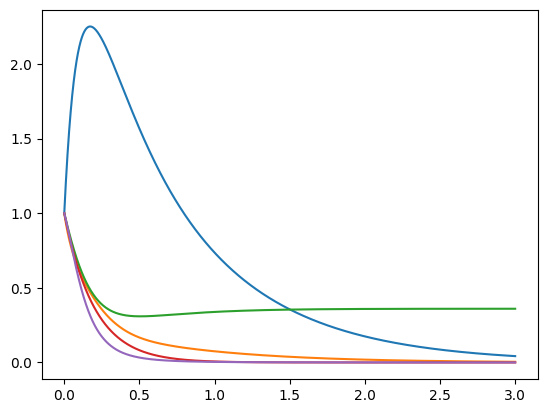

In [ ]:
plt.plot(t, x_train)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class AutoencoderSINDy(nn.Module):
    def __init__(self, input_size,  latent_size) -> None:
        super().__init__()
        self.sindy_weights = nn.Linear(25, 5).to(torch.float64)
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 10).to(torch.float64),
            nn.ReLU(),
            nn.Linear(10,  5).to(torch.float64),
            nn.ReLU(),
            nn.Linear(5, 5).to(torch.float64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(5, 5).to(torch.float64),
            nn.ReLU(),
            nn.Linear(5, input_size).to(torch.float64),
            nn.ReLU()
        )
    def forward(self, x) -> tuple:
        x.requires_grad_(True)
        z = self.encoder(x)
        z.requires_grad_(True)
        sindy_library = torch.cat([torch.sin(z), torch.cos(z), torch.pow(z, 1), torch.pow(z, 2), torch.pow(z, 3)], dim = 1)
        dz_sindy = self.sindy_weights(sindy_library)
        x_decoder = self.decoder(z)
        dz_dx = torch.autograd.grad(outputs=z, inputs=x, grad_outputs=torch.ones_like(z), create_graph=True)[0]
        dx_decoder_dx = torch.autograd.grad(outputs=x_decoder, inputs=z, grad_outputs=torch.ones_like(x_decoder), create_graph=True)[0]

        return z, dz_sindy, x_decoder, dz_dx, dx_decoder_dx, self.sindy_weights.weight


class Dados(Dataset):
    def __init__(self, data) -> None:
        self.data: list[tuple[list, list]] = data
    def __len__(self) -> int:
        return len(self.data);

    def __getitem__(self, idx: int) -> tuple[list, list]:
        return self.data[idx];

In [ ]:
train_dataset = Dados(dados)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

In [ ]:
def sindy_va_loss(data_set, z, dz_sindy, output, dz_dx, dx_decoder_dx, sindy_weights, l1, l2, l3) -> float:
    x, x_dot = data_set
    loss = nn.MSELoss()
    return loss(output,  x) + l2*torch.norm(sindy_weights, p = 1) + l3*loss(x_dot, dx_decoder_dx*dz_sindy) + l1*loss(x_dot*dz_dx, dz_sindy)

In [ ]:
def train(data, model, optimizer, sindy_va_loss):
    x, x_dot = data
    model.train()
    optimizer.zero_grad()
    z, dz_sindy, output, dz_dx, dx_decoder_dx, sindy_weights = model(x)
    loss = sindy_va_loss(data, z, dz_sindy, output,  dz_dx, dx_decoder_dx, sindy_weights, 0.5, 0.2, 0.3)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def validate_batch(data, model, sindy_va_loss):
    model.eval()
    z, dz_sindy, output, grad_encoder, grad_decoder = model(x)
    loss = sindy_va_loss(data, z, dz_sindy, output, 0.5, 0.2, 0.3)
    return loss


In [ ]:
model = AutoencoderSINDy(5, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 150
for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, data in enumerate(train_loader):
        loss = train(data, model, optimizer, sindy_va_loss)
        pos = epoch + (1+batch_idx)/N
    print(f"epoch: {epoch} | loss: {loss}")

epoch: 0 | loss: 0.42334489529403657
epoch: 1 | loss: 0.5764073508233248
epoch: 2 | loss: 1.2535374768779495
epoch: 3 | loss: 2.6233611250234703
epoch: 4 | loss: 0.28881411656849326
epoch: 5 | loss: 1.3608457785828771
epoch: 6 | loss: 0.2888241738172985
epoch: 7 | loss: 0.04272168378461983
epoch: 8 | loss: 0.26506954284401324
epoch: 9 | loss: 0.486571699562011
epoch: 10 | loss: 1.9710196912483586
epoch: 11 | loss: 0.18663549608558802
epoch: 12 | loss: 1.3258829003071002
epoch: 13 | loss: 0.7415884059762052
epoch: 14 | loss: 0.6772679533683428
epoch: 15 | loss: 0.0573563657347473
epoch: 16 | loss: 1.401236260522489
epoch: 17 | loss: 3.2585623640179087
epoch: 18 | loss: 0.23067133617429023
epoch: 19 | loss: 0.4767141900783706
epoch: 20 | loss: 0.029610550050306196
epoch: 21 | loss: 0.3696979329589807
epoch: 22 | loss: 0.4936251768147877
epoch: 23 | loss: 0.11052318390609717
epoch: 24 | loss: 0.3384873609666932
epoch: 25 | loss: 1.6767435513346995
epoch: 26 | loss: 0.23940322378234596
epo